**Loan Approval System**
We'll build a LangGraph workflow that:

Gathers applicant data
Calculates a credit score
Decides based on multiple thresholds:
🟢 Approve loan
🟡 Refer to manual review
🔴 Reject loan
Each condition leads to a different downstream path with more logic.

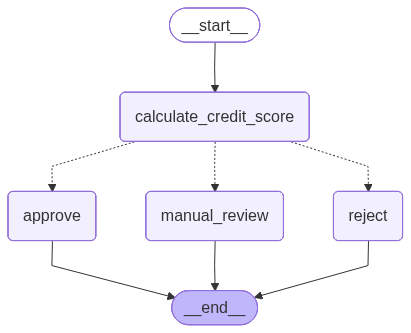

In [13]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
import matplotlib.pyplot as plt
from IPython.display import Image, display

class LoanStatus(TypedDict):
    name: str
    age: int
    income: int
    loan_amount: float
    credit_score: float
    decision: str
    remarks: str

def calculate_credit_score(state: LoanStatus) -> LoanStatus:
    # Simple credit score calculation based on income and loan amount
    if state['income'] <= 0 or state['loan_amount'] <= 0:
        score = 0.0
    else:
        score = (state['income'] / state['loan_amount']) * 100
        score = min(score, 850.0)
    return {'credit_score': score}

def evaluate_credit_score(state: LoanStatus) -> Literal['approve', 'manual_review', 'reject']:
    score = state['credit_score']
    if score >= 250:
        return 'approve'
    elif 150 <= score < 250:
        return 'manual_review'
    else:
        return 'reject'

def approve_loan(state: LoanStatus) -> LoanStatus:
    return {
        'decision': 'Approved ✅',
        'remarks': f"Loan approved for {state['name']}"
    }

def manual_review(state: LoanStatus) -> LoanStatus:
    remarks = f"Loan referred for manual review for {state['name']}."
    return {"decision": "Pending Manual Review 🕵️‍♂️", "remarks": remarks}

def reject_loan(state: LoanStatus) -> LoanStatus:
    return {
        "decision": "Rejected ❌",
        "remarks": f"Loan rejected for {state['name']} due to low credit score ({state['credit_score']:.2f})"
    }

# Create the graph
graph = StateGraph(LoanStatus)

# Add nodes
graph.add_node("calculate_credit_score", calculate_credit_score)
graph.add_node("approve", approve_loan)
graph.add_node("manual_review", manual_review)
graph.add_node("reject", reject_loan)

# Define the flow
graph.add_edge(START, "calculate_credit_score")

# Connect calculate_credit_score to decision nodes based on condition
graph.add_conditional_edges(
    "calculate_credit_score", 
    evaluate_credit_score,
    {
        'approve': 'approve',
        'manual_review': 'manual_review',
        'reject': 'reject'
    }
)

# Connect all decision nodes to END
graph.add_edge("approve", END)
graph.add_edge("manual_review", END)
graph.add_edge("reject", END)

# Compile
workflow = graph.compile()

# Visualize the graph
try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except:
    # If visualization fails, print the graph structure
    print("Graph Structure:")
    print("START -> calculate_credit_score")
    print("calculate_credit_score -> (conditional)")
    print("  ├─ if score >= 250 -> approve -> END")
    print("  ├─ if 150 <= score < 250 -> manual_review -> END")
    print("  └─ if score < 150 -> reject -> END")


In [14]:
test_cases = [
    {
        'name': 'High Score',
        'age': 35,
        'income': 100000,
        'loan_amount': 200000,  # income/loan_amount = 0.5 * 100 = 50 -> score=50
        'credit_score': 0.0,
        'decision': '',
        'remarks': ''
    },
    {
        'name': 'Medium Score',
        'age': 40,
        'income': 80000,
        'loan_amount': 400000,  # income/loan_amount = 0.2 * 100 = 20 -> score=20
        'credit_score': 0.0,
        'decision': '',
        'remarks': ''
    },
    {
        'name': 'Low Score',
        'age': 25,
        'income': 30000,
        'loan_amount': 500000,  # income/loan_amount = 0.06 * 100 = 6 -> score=6
        'credit_score': 0.0,
        'decision': '',
        'remarks': ''
    }
]

print("\n" + "="*50)
print("Testing Loan Approval System")
print("="*50)

for test in test_cases:
    print(f"\nApplicant: {test['name']}")
    print(f"Income: ${test['income']:,}")
    print(f"Loan Amount: ${test['loan_amount']:,}")
    
    result = workflow.invoke(test)
    
    print(f"Credit Score: {result['credit_score']:.2f}")
    print(f"Decision: {result['decision']}")
    print(f"Remarks: {result['remarks']}")
    print("-" * 30)


Testing Loan Approval System

Applicant: High Score
Income: $100,000
Loan Amount: $200,000
Credit Score: 50.00
Decision: Rejected ❌
Remarks: Loan rejected for High Score due to low credit score (50.00)
------------------------------

Applicant: Medium Score
Income: $80,000
Loan Amount: $400,000
Credit Score: 20.00
Decision: Rejected ❌
Remarks: Loan rejected for Medium Score due to low credit score (20.00)
------------------------------

Applicant: Low Score
Income: $30,000
Loan Amount: $500,000
Credit Score: 6.00
Decision: Rejected ❌
Remarks: Loan rejected for Low Score due to low credit score (6.00)
------------------------------
